In [2]:
!pip install fluidsim
!pip install fluidfft
!pip install pyfftw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.8/161.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.6/246.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.5 MB/s eta 0:00:0000:0100:01


# Generating Simulation frames for training

I am mostly working fully in notebooks since it is easier to modify things all over the code for now, so I hope it is fine, that some code from distinct files is just a copy-paste from this. This notebook is for demonstration purposes to show the idea of a future pipeline, later this will be structured a bit differently, but there is no point in this when the project is only half way completed

*************************************
Program fluidsim
To plot the forcing modes, you can use:
sim.forcing.forcing_maker.plot_forcing_region()
sim:                <class 'fluidsim.solvers.ns2d.solver.Simul'>
sim.output:         <class 'fluidsim.solvers.ns2d.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators2d.OperatorsPseudoSpectral2D'>
sim.state:          <class 'fluidsim.solvers.ns2d.state.StateNS2D'>
sim.time_stepping:  <class 'fluidsim.base.time_stepping.pseudo_spect.TimeSteppingPseudoSpectral'>
sim.init_fields:    <class 'fluidsim.solvers.ns2d.init_fields.InitFieldsNS2D'>
sim.forcing:        <class 'fluidsim.solvers.ns2d.forcing.ForcingNS2D'>

solver NS2D, RK4 and sequential,
type fft: fluidfft.fft2d.with_pyfftw
nx =     64 ; ny =     64
lx = 10 ; ly = 10
path_run =
/root/Sim_data/NS2D_ocean_currents_64x64_S10x10_2025-03-10_20-58-28
init_fields.type: dipole

Initialization outputs:
sim.output.increments:        <class 'fluidsim.base.output.increments.Incremen

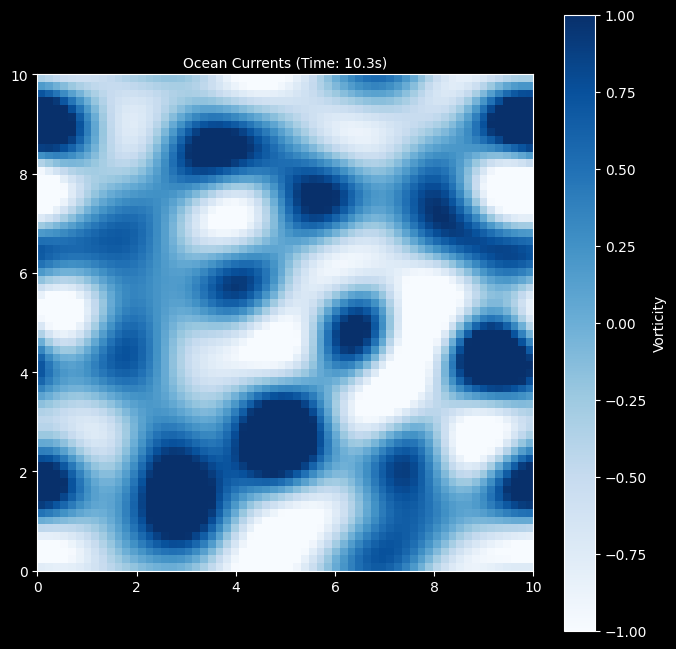

In [3]:
import os
import fluiddyn as fld
from fluidsim.solvers.ns2d.solver import Simul
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

t_end = 10.0
nh = 64
Lh = 10.0 

params = Simul.create_default_params()

params.short_name_type_run = "ocean_currents"
params.oper.nx = params.oper.ny = nh
params.oper.Lx = params.oper.Ly = Lh

params.nu_8 = 1e-4
params.forcing.forcing_rate = 0.1
params.time_stepping.t_end = t_end
params.init_fields.type = "dipole" 
params.forcing.enable = True
params.forcing.type = "tcrandom"

params.output.ONLINE_PLOT_OK = False
params.output.periods_plot.phys_fields = 0.0
params.output.periods_save.phys_fields = 0.0

sim = Simul(params)

output_dir = "training_data"
os.makedirs(output_dir, exist_ok=True)

frames = []
current_time = 0.0
dt_frame = 0.1

def create_frame():
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, Lh)
    ax.set_ylim(0, Lh)
    ax.set_aspect("equal")
    ax.set_facecolor("midnightblue")
    return fig, ax

fig, ax = create_frame()
im = ax.imshow(np.zeros((nh, nh)), cmap="Blues", extent=[0, Lh, 0, Lh], vmin=-1, vmax=1)
plt.colorbar(im, label="Vorticity")
title = ax.set_title("Ocean Currents (Time: 0.0s)")

frame_count = 0
def update(frame):
    global current_time, frame_count
    while sim.time_stepping.t < current_time:
        sim.time_stepping.one_time_step()
    current_time += dt_frame
    
    vorticity = sim.state.get_var("rot")
    im.set_array(vorticity)
    title.set_text(f"Ocean Currents (Time: {current_time:.1f}s)")
    
    np.save(os.path.join(output_dir, f"frame_{frame_count:04d}.npy"), vorticity)
    frame_count += 1
    return im, title

ani = FuncAnimation(fig, update, frames=int(t_end / dt_frame), interval=100, blit=True)

output_path = "ocean_currents.mp4"
writer = FFMpegWriter(fps=10, metadata=dict(artist="You"), bitrate=1800)
ani.save(output_path, writer=writer)
Video(output_path, embed=True)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, sequence_length):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim)
        )
        self.lstm = nn.LSTM(latent_dim, latent_dim, num_layers=2, batch_first=True)
        self.sequence_length = sequence_length

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=-1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        batch_size, seq_len, h, w = x.size()
        x = x.view(batch_size * seq_len, -1)
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        z = z.view(batch_size, seq_len, -1)
        z, _ = self.lstm(z)
        z = z.contiguous().view(batch_size * seq_len, -1)
        x_recon = self.decode(z)
        x_recon = x_recon.view(batch_size, seq_len, h, w)
        return x_recon, mean, logvar

class OceanCurrentsDataset(Dataset):
    def __init__(self, data_dir, sequence_length):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])

    def __len__(self):
        return len(self.files) - self.sequence_length + 1

    def __getitem__(self, idx):
        frames = [np.load(os.path.join(self.data_dir, self.files[i])) for i in range(idx, idx + self.sequence_length)]
        frames = np.stack(frames)
        return torch.tensor(frames, dtype=torch.float32)

def train_vae(model, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    kl_weight = 0.0
    kl_weight_increment = 0.01
    for epoch in range(epochs):
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            x_recon, mean, logvar = model(batch)
            recon_loss = nn.functional.mse_loss(x_recon, batch)
            kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            loss = recon_loss + kl_weight * kl_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
        scheduler.step()
        kl_weight = min(1.0, kl_weight + kl_weight_increment)
        avg_loss = total_loss / len(dataloader)
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_kl_loss = total_kl_loss / len(dataloader)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, KL Weight: {kl_weight:.2f}')

input_dim = nh * nh
hidden_dim = 128
latent_dim = 64
sequence_length = 10

model = VAE(input_dim, hidden_dim, latent_dim, sequence_length)
dataset = OceanCurrentsDataset(output_dir, sequence_length)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

train_vae(model, dataloader, epochs=30, lr=1e-3)  # Use adjusted learning rate and epochs 

Epoch 1, Loss: 0.3249, Recon Loss: 0.3249, KL Loss: 30758.0492, KL Weight: 0.01
Epoch 2, Loss: 91.0565, Recon Loss: 0.2188, KL Loss: 9083.7737, KL Weight: 0.02
Epoch 3, Loss: 0.3055, Recon Loss: 0.2117, KL Loss: 4.6873, KL Weight: 0.03
Epoch 4, Loss: 0.3022, Recon Loss: 0.1873, KL Loss: 3.8271, KL Weight: 0.04
Epoch 5, Loss: 0.2989, Recon Loss: 0.1858, KL Loss: 2.8266, KL Weight: 0.05
Epoch 6, Loss: 0.2895, Recon Loss: 0.1828, KL Loss: 2.1336, KL Weight: 0.06
Epoch 7, Loss: 0.2866, Recon Loss: 0.1830, KL Loss: 1.7255, KL Weight: 0.07
Epoch 8, Loss: 0.2760, Recon Loss: 0.1812, KL Loss: 1.3536, KL Weight: 0.08
Epoch 9, Loss: 0.2645, Recon Loss: 0.1818, KL Loss: 1.0332, KL Weight: 0.09
Epoch 10, Loss: 0.2511, Recon Loss: 0.1819, KL Loss: 0.7687, KL Weight: 0.10
Epoch 11, Loss: 0.2399, Recon Loss: 0.1799, KL Loss: 0.6005, KL Weight: 0.11
Epoch 12, Loss: 0.2377, Recon Loss: 0.1822, KL Loss: 0.5045, KL Weight: 0.12
Epoch 13, Loss: 0.2300, Recon Loss: 0.1800, KL Loss: 0.4165, KL Weight: 0.13


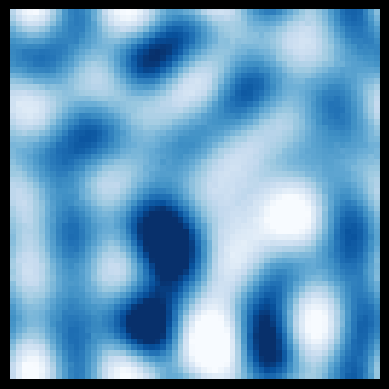

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def generate_video(model, input_frame, sequence_length):
    model.eval()
    with torch.no_grad():
        if input_frame.dim() == 2:
            input_frame = input_frame.unsqueeze(0).unsqueeze(0)
        elif input_frame.dim() == 3:
            input_frame = input_frame.unsqueeze(0)
        _, _, h, w = input_frame.size()
        input_frame = input_frame.view(1, -1)
        mean, logvar = model.encode(input_frame)
        z = model.reparameterize(mean, logvar)
        z = z.unsqueeze(1).repeat(1, sequence_length, 1)
        z, _ = model.lstm(z)
        z = z.contiguous().view(sequence_length, -1)
        frames = model.decode(z)
        frames = frames.view(sequence_length, h, w)
    return frames.cpu().numpy()

def visualize_video(frames):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    im = ax.imshow(frames[0], cmap='Blues', vmin=-1, vmax=1)

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames, blit=True)
    return HTML(ani.to_jshtml())

sample_idx = 0
input_frame = dataset[sample_idx][0]

predicted_frames = generate_video(model, input_frame, sequence_length)

visualize_video(predicted_frames) 

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def generate_frames(model, input_sequence):
    model.eval()
    with torch.no_grad():
        if input_sequence.dim() == 3:
            input_sequence = input_sequence.unsqueeze(0)
        batch_size, seq_len, h, w = input_sequence.size()
        input_sequence = input_sequence.view(batch_size * seq_len, -1)
        mean, logvar = model.encode(input_sequence)
        z = model.reparameterize(mean, logvar)
        z = z.view(batch_size, seq_len, -1)
        z, _ = model.lstm(z)
        z = z.contiguous().view(batch_size * seq_len, -1)
        generated_frames = model.decode(z)
        generated_frames = generated_frames.view(batch_size, seq_len, h, w)
    return generated_frames.cpu().numpy()

def visualize_comparison(input_frames, generated_frames):
    num_frames = input_frames.shape[0]
    fig, axes = plt.subplots(2, num_frames, figsize=(15, 4))
    mse_values = []
    for i in range(num_frames):
        print(f'Shape of input frame {i+1}: {input_frames[i].shape}')
        print(f'Shape of generated frame {i+1}: {generated_frames[i].shape}')
        
        axes[0, i].imshow(input_frames[i], cmap='Blues', vmin=-1, vmax=1)
        axes[0, i].set_title(f'Input Frame {i+1}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(generated_frames[i], cmap='Blues', vmin=-1, vmax=1)
        axes[1, i].set_title(f'Generated Frame {i+1}')
        axes[1, i].axis('off')
        
        mse = np.mean((input_frames[i] - generated_frames[i]) ** 2)
        mse_values.append(mse)
        print(f'Frame {i+1} MSE: {mse:.4f}')
    plt.tight_layout()
    plt.show()
    return mse_values

sample_idx = 0
input_sequence = dataset[sample_idx] 

generated_frames = generate_frames(model, input_sequence)

mse_values = visualize_comparison(input_sequence.numpy(), generated_frames) 